# demand-prediction
---

### 1. Exploratory Data Analysis
#### _1.1 Set up_

In [14]:
#load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LassoCV, ElasticNetCV, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from keras.models import Sequential
from keras.layers import Dense

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

np.random.seed(42)

In [15]:
#load data
train = pd.read_csv('training.csv')

In [16]:
#load test data
test = pd.read_csv('test.csv')

In [17]:
#read data
train.head()

,Hours,Workers,Town,Summer,Amenity,Prev,Demand
0,10.18,10,1,0,0,0,72.750556
1,9.74,10,1,1,0,0,66.720482
2,0.96,2,0,0,0,1,19.189516
3,9.58,9,1,1,0,1,67.388669
4,1.03,4,0,1,0,1,15.813127


In [18]:
#check for missing data
total = train.isnull().sum()
missing_data = pd.concat([total], axis=1, keys=['Total'])
missing_data

#no missing data so we can proceed

,Total
Hours,0
Workers,0
Town,0
Summer,0
Amenity,0
Prev,0
Demand,0


#### _1.2 Visualise Relationships_

<AxesSubplot:>

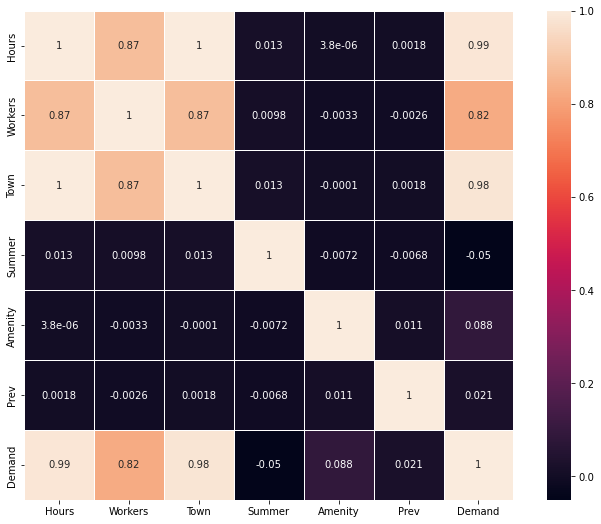

In [19]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True, linewidths=0.5, cmap='rocket', annot=True)

#strong correlation between Hours, Workers and Town
#indicates multicollinearity

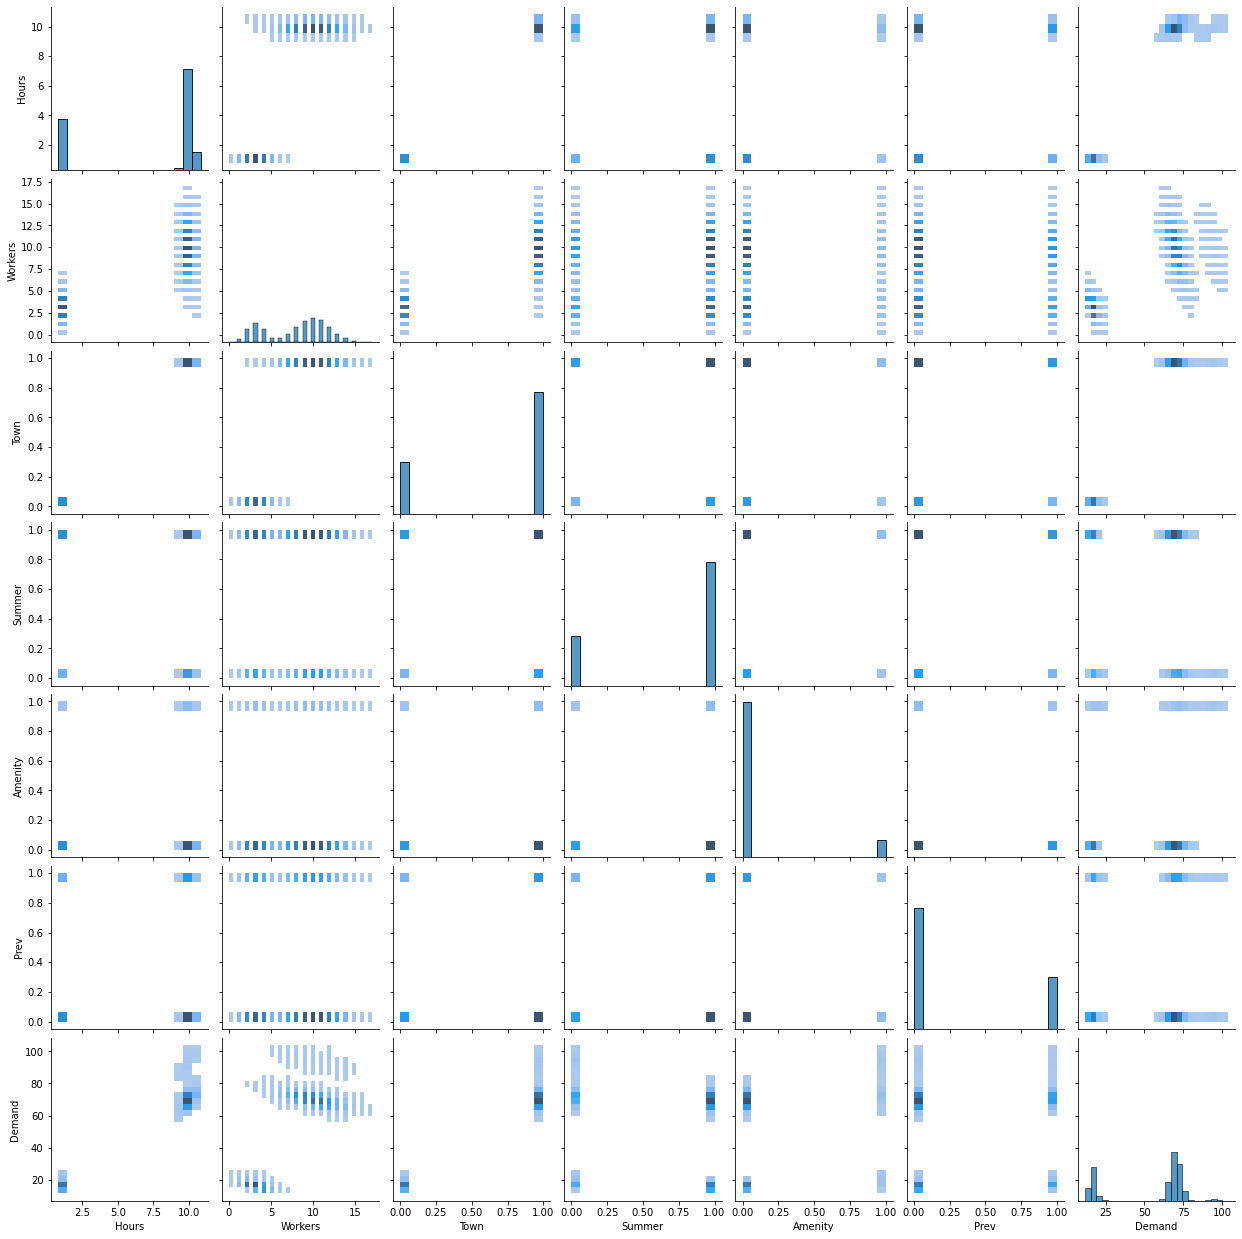

In [20]:
#plot relationships
sns.pairplot(train, kind='hist')

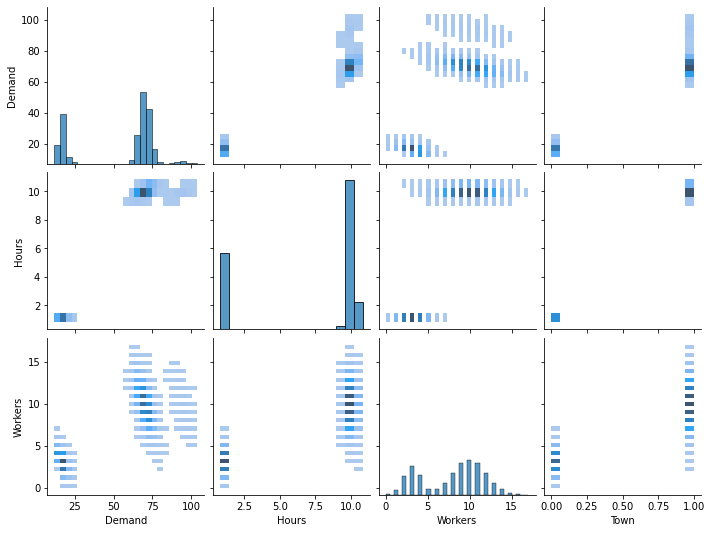

In [21]:
#focus on important relationships (Hours, Workers, Town)
sns.pairplot(
    train,
    x_vars=['Demand', 'Hours', 'Workers', 'Town'],
    y_vars=['Demand', 'Hours', 'Workers'],
    kind='hist'
)

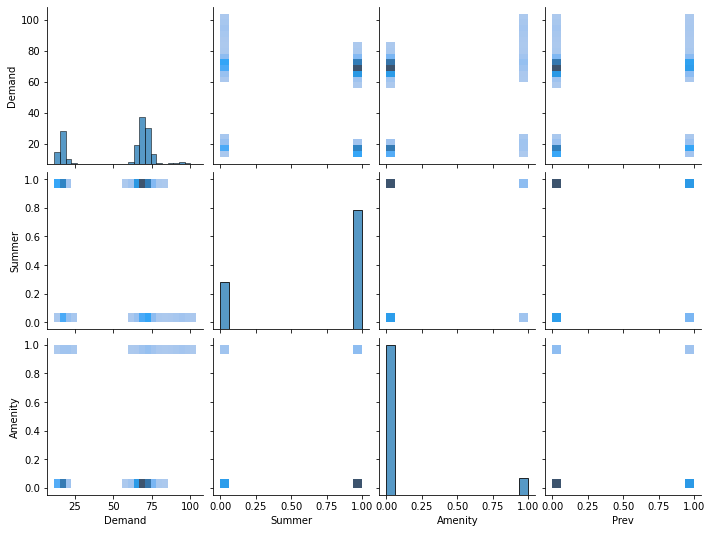

In [22]:
#plot less interesting variables
sns.pairplot(
    train,
    x_vars=['Demand', 'Summer', 'Amenity', 'Prev'],
    y_vars=['Demand', 'Summer', 'Amenity'],
    kind='hist'
)

#### _1.3 Analyse the response variable 'Demand'_

In [23]:
#descriptive stats
train['Demand'].describe()

#minimum>0 -> great!

count    22000.000000
mean        54.652818
std         25.099767
min         11.668197
25%         18.500386
50%         68.240749
75%         71.345778
max        103.964065
Name: Demand, dtype: float64

<AxesSubplot:xlabel='Demand', ylabel='Density'>

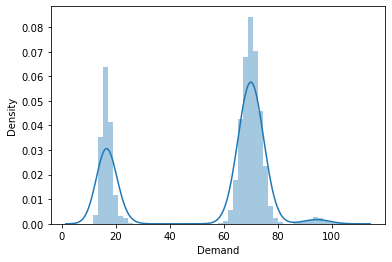

In [24]:
#histogram
sns.distplot(train['Demand'], bins=50)

#bimodal/multimodal distribution

In [25]:
#skewness and kurtosis
print("Skewness: %f" % train['Demand'].skew())
print("Kurtosis: %f" % train['Demand'].kurt())

#not that informative

Skewness: -0.772358
Kurtosis: -1.170558


<AxesSubplot:>

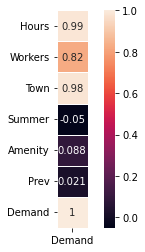

In [27]:
#Demand correlation matrix
cm = pd.DataFrame(train[train.columns].corr()['Demand'][:])
sns.heatmap(cm, square=True, linewidths=0.5, cmap='rocket', annot=True)

#Hours, Town, Workers strongly correlated with Demand
#Summer, Amenity, Prev very weak correlation

<AxesSubplot:xlabel='Hours', ylabel='Demand'>

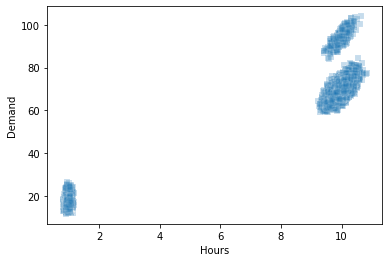

In [28]:
#scatterplot Hours/Demand
sns.scatterplot(data=train, x='Hours', y='Demand', alpha=0.25, marker='s')

#clear separation into 2-3 groups (low, moderate, Prev)
#Hours separate low from moderate and Prev groups

<AxesSubplot:xlabel='Workers', ylabel='Demand'>

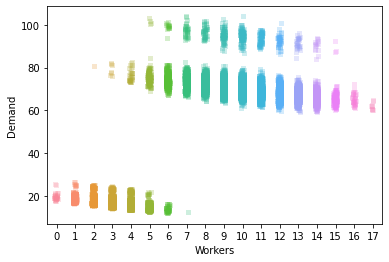

In [29]:
#strip plot Workers/Demand
sns.stripplot(data=train, x='Workers', y='Demand', alpha=0.25, marker='s')

#clear separation into 2-3 groups (possibly related to Town)
#overlap between groups by number of nearby Workers

<AxesSubplot:xlabel='Workers', ylabel='Demand'>

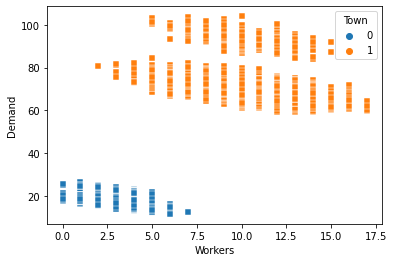

In [30]:
#scatterplot Workers/Demand with Town hue
sns.scatterplot(data=train, x='Workers', y='Demand', marker='s', hue='Town')

#heterogeneity between low and moderate/Prev groups related to Town

<AxesSubplot:xlabel='Workers', ylabel='Demand'>

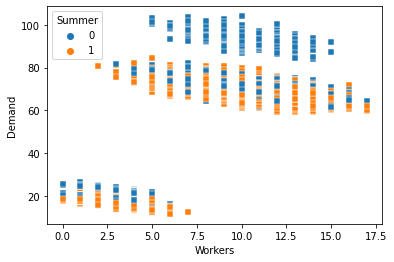

In [31]:
#scatterplot Workers/Demand with Summer hue
sns.scatterplot(data=train, x='Workers', y='Demand', marker='s', hue='Summer')

#heterogeneity within groups related to Summer and Amenity

<AxesSubplot:xlabel='Workers', ylabel='Demand'>

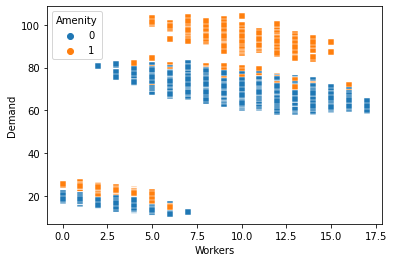

In [32]:
#scatterplot Workers/Demand with Amenity hue
sns.scatterplot(data=train, x='Workers', y='Demand', marker='s', hue='Amenity')

#heterogeneity within groups related to Summer and Amenity

<AxesSubplot:xlabel='Town', ylabel='Demand'>

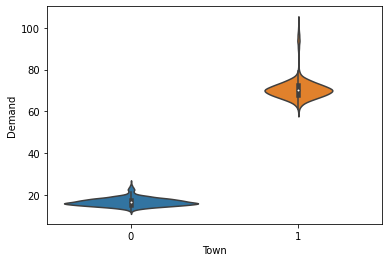

In [33]:
#violinplot Town/Demand
sns.violinplot(data=train, x='Town', y='Demand')

#stark difference between Town Workers and non-Town Workers

<AxesSubplot:xlabel='Summer', ylabel='Demand'>

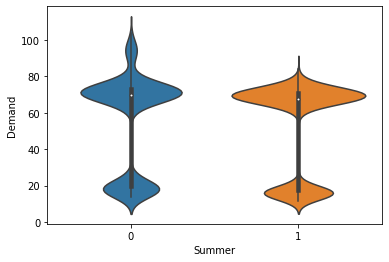

In [34]:
#violinplot Summer/Demand
sns.violinplot(data=train, x='Summer', y='Demand')

#fairly uniform
#Prever maximum for weekends

<AxesSubplot:xlabel='Amenity', ylabel='Demand'>

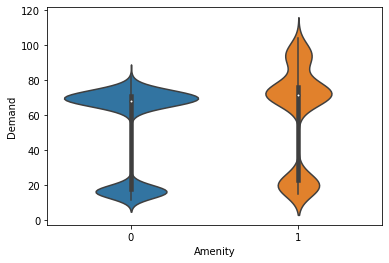

In [35]:
#violinplot Amenity/Demand
sns.violinplot(data=train, x='Amenity', y='Demand')

#fairly uniform
#Prever maximum for in-Amenity Workers

<AxesSubplot:xlabel='Prev', ylabel='Demand'>

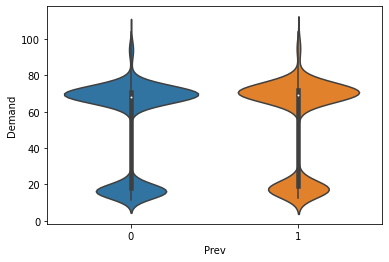

In [36]:
#violinplot Prev/Demand
sns.violinplot(data=train, x='Prev', y='Demand')

#very uniform, no difference in Demand

In [37]:
#check for outliers
Demand_scaled = StandardScaler().fit_transform(train['Demand'][:,np.newaxis])
low_range = Demand_scaled[Demand_scaled[:,0].argsort()][:10]
Prev_range = Demand_scaled[Demand_scaled[:,0].argsort()][-10:]
print('low range of the distribution:')
print(low_range)
print('\nPrev range of the distribution:')
print(Prev_range)

#low and Prev range values are similar and not too far from 0
#we will not consider any of these values as outliers
#confirms lack of clear visual outliers

low range of the distribution:
[[-1.71258952]
 [-1.70363358]
 [-1.6977112 ]
 [-1.69381223]
 [-1.69226695]
 [-1.69141071]
 [-1.69077323]
 [-1.68561822]
 [-1.68412387]
 [-1.68249184]]

Prev range of the distribution:
[[1.85055334]
 [1.86209709]
 [1.86952458]
 [1.87349249]
 [1.88199759]
 [1.91310776]
 [1.93186278]
 [1.93921519]
 [1.95957352]
 [1.96465444]]


### 2. Feature Engineering
#### _2.1 Feature Construction_

<AxesSubplot:xlabel='Demand', ylabel='Count'>

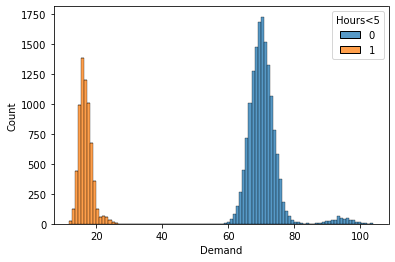

In [38]:
#create binary variable for Hours<5
train['Hours<5'] = (train['Hours']<5) * 1
test['Hours<5'] = (test['Hours']<5) * 1

#enables models to separate low from moderate/Prev Demandal Workers
sns.histplot(data=train, x='Demand', hue='Hours<5', multiple='stack', bins=100)

In [39]:
#create Weekend variable (inverse of Summer)
train['Weekend'] = 1 - train['Summer']
test['Weekend'] = 1 - test['Summer']

#for ease of creating interaction terms below

<AxesSubplot:xlabel='Demand', ylabel='Count'>

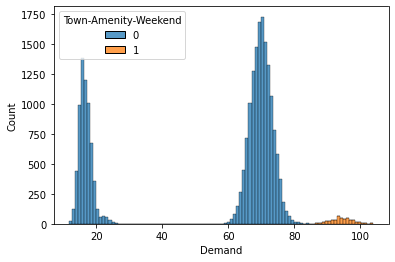

In [40]:
#create interaction variable Town*Amenity*Weekend
train['Town-Amenity-Weekend'] = train['Town'] * train['Amenity'] * train['Weekend']
test['Town-Amenity-Weekend'] = test['Town'] * test['Amenity'] * test['Weekend']

#enables models to separate moderate from Prev Demandal Workers
sns.histplot(data=train, x='Demand', hue='Town-Amenity-Weekend', multiple='stack', bins=100)

<AxesSubplot:xlabel='Demand', ylabel='Count'>

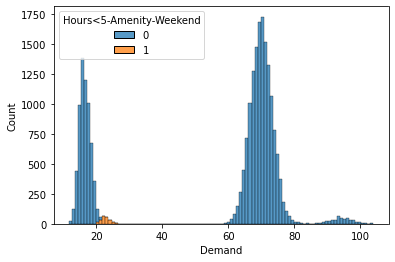

In [41]:
#create interaction variable Hours<5*Amenity*Weekend
train['Hours<5-Amenity-Weekend'] = train['Hours<5'] * train['Amenity'] * train['Weekend']
test['Hours<5-Amenity-Weekend'] = test['Hours<5'] * test['Amenity'] * test['Weekend']

#enables models to separate low from super-low Demandal Workers
sns.histplot(data=train, x='Demand', hue='Hours<5-Amenity-Weekend', multiple='stack', bins=100)

<AxesSubplot:xlabel='Demand', ylabel='Count'>

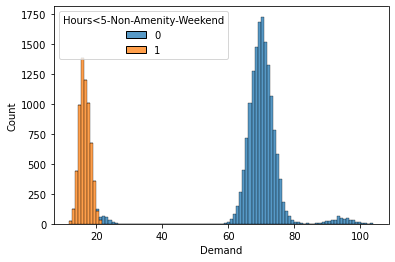

In [42]:
#create interaction variable Hours<5*Amenity*Weekend
train['Hours<5-Non-Amenity-Weekend'] = train['Hours<5'] * (1-train['Hours<5-Amenity-Weekend'])
test['Hours<5-Non-Amenity-Weekend'] = test['Hours<5'] * (1-test['Hours<5-Amenity-Weekend'])

#enables models to separate low from super-low Demandal Workers
sns.histplot(data=train, x='Demand', hue='Hours<5-Non-Amenity-Weekend', multiple='stack', bins=100)

In [43]:
#create polynomial features from numerical variables
train['Workers2'] = train['Workers']**2
train['Workers3'] = train['Workers']**3
train['WorkersR'] = np.sqrt(train['Workers'])
train['Hours2'] = train['Hours']**2
train['Hours3'] = train['Hours']**3
train['HoursR'] = np.sqrt(train['Hours'])

In [44]:
#repeat for test data
test['Workers2'] = test['Workers']**2
test['Workers3'] = test['Workers']**3
test['WorkersR'] = np.sqrt(test['Workers'])
test['Hours2'] = test['Hours']**2
test['Hours3'] = test['Hours']**3
test['HoursR'] = np.sqrt(test['Hours'])

In [45]:
#check that columns in train and test dataset are the same
print(train.columns==test.columns)
train.head()

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


,Hours,Workers,Town,Summer,Amenity,Prev,Demand,Hours<5,Weekend,Town-Amenity-Weekend,Hours<5-Amenity-Weekend,Hours<5-Non-Amenity-Weekend,Workers2,Workers3,WorkersR,Hours2,Hours3,HoursR
0,10.18,10,1,0,0,0,72.750556,0,1,0,0,0,100,1000,3.162278,103.6324,1054.977832,3.190611
1,9.74,10,1,1,0,0,66.720482,0,0,0,0,0,100,1000,3.162278,94.8676,924.010424,3.120897
2,0.96,2,0,0,0,1,19.189516,1,1,0,0,1,4,8,1.414214,0.9216,0.884736,0.979796
3,9.58,9,1,1,0,1,67.388669,0,0,0,0,0,81,729,3.000000,91.7764,879.217912,3.095158
4,1.03,4,0,1,0,1,15.813127,1,0,0,0,1,16,64,2.000000,1.0609,1.092727,1.014889


#### _2.2 Standardisation_

In [46]:
#list target variable
target = ['Demand']

#list numerical and categorical features
categorical_features = ['Town', 'Amenity', 'Prev', 'Summer', 'Town-Amenity-Weekend', 'Hours<5', 'Hours<5-Amenity-Weekend', 'Hours<5-Non-Amenity-Weekend']
numerical_features = ['Workers', 'Workers2', 'Workers3', 'WorkersR', 'Hours', 'Hours2', 'Hours3', 'HoursR']
print('Target variable: ' + str(target))
print('Numerical features: ' + str(len(numerical_features)))
print('Categorical features: ' + str(len(categorical_features)))
print('Total features: ' + str(len(categorical_features)+len(numerical_features)))

Target variable: ['Demand']
Numerical features: 8
Categorical features: 8
Total features: 16


In [47]:
#split train into a training set and validation set
#training set to be used for fitting models and cross-validating hyperparameters
#validation set to be used for model evaluation and comparison
X = pd.concat([train[numerical_features], train[categorical_features]], axis=1)
y = train[target]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, shuffle=True)

In [49]:
#find mean and standard deviation of training set numerical predictors
mu = X_train[numerical_features].mean()
sigma = X_train[numerical_features].std()

In [50]:
#standardise numerical predictors
X_train[numerical_features] = (X_train[numerical_features]-mu) / sigma
X_test[numerical_features] = (X_test[numerical_features]-mu) / sigma

test[numerical_features] = (test[numerical_features]-mu) / sigma

In [51]:
#check for mean=0
X_train[numerical_features].mean().round(4)

#check passed

Workers    -0.0
Workers2    0.0
Workers3    0.0
WorkersR    0.0
Hours      -0.0
Hours2     -0.0
Hours3     -0.0
HoursR      0.0
dtype: float64

In [52]:
#check for standard deviation=1
X_train[numerical_features].std()

#check passed

Workers     1.0
Workers2    1.0
Workers3    1.0
WorkersR    1.0
Hours       1.0
Hours2      1.0
Hours3      1.0
HoursR      1.0
dtype: float64

### 3. Model Development
#### _3.1 Linear regression without regularisation_

In [53]:
#fit model
lr = LinearRegression()
lr.fit(X_train, np.ravel(y_train))

#store predicted values and residuals on training data
lr_train_preds = pd.DataFrame({'preds':lr.predict(X_train), 'true':np.ravel(y_train)})
lr_train_preds['residuals'] = lr_train_preds['true'] - lr_train_preds['preds']

#store predicted values and residuals on test data
lr_test_preds = pd.DataFrame({'preds':lr.predict(X_test), 'true':np.ravel(y_test)})
lr_test_preds['residuals'] = lr_train_preds['true'] - lr_train_preds['preds']

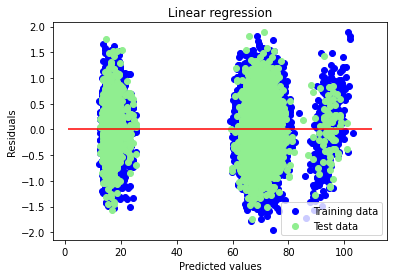

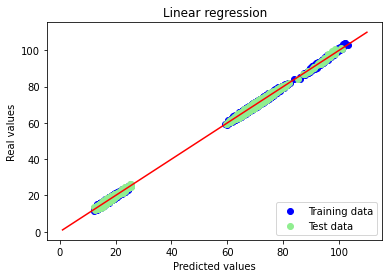

In [54]:
#plot residuals versus predictions
plt.scatter(lr_train_preds['preds'], lr_train_preds['residuals'], c='blue', label='Training data')
plt.scatter(lr_test_preds['preds'], lr_test_preds['residuals'], c='lightgreen', label='Test data')
plt.title('Linear regression')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='lower right')
plt.hlines(y=0, xmin=1, xmax=110, color='red')
plt.show()

#plot real values versus predictions
plt.scatter(lr_train_preds['preds'], lr_train_preds['true'], c='blue', label='Training data')
plt.scatter(lr_test_preds['preds'], lr_test_preds['true'], c='lightgreen', label='Test data')
plt.title('Linear regression')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc='lower right')
plt.plot([1, 110], [1, 110], c='red')
plt.show()

In [55]:
lr_mse = mean_squared_error(lr_test_preds['true'], lr_test_preds['preds'])
print('MSE on the test data for linear regression:', lr_mse.round(4))

MSE on the test data for linear regression: 0.2546


#### _3.2 Linear regression with ridge regularisation_

In [56]:
#fit model using cross-validated penalty term
alphas=np.exp(np.linspace(-100, 10, 500))
ridge_cv = RidgeCV(alphas=alphas, cv=10)
ridge_cv.fit(X_train, np.ravel(y_train))

#store as ridge object
ridge = Ridge(alpha=ridge_cv.alpha_)
ridge.fit(X_train, np.ravel(y_train))

#store predicted values and residuals on training data
ridge_train_preds = pd.DataFrame({'preds':ridge.predict(X_train), 'true':np.ravel(y_train)})
ridge_train_preds['residuals'] = ridge_train_preds['true'] - ridge_train_preds['preds']

#store predicted values and residuals on test data
ridge_test_preds = pd.DataFrame({'preds':ridge.predict(X_test), 'true':np.ravel(y_test)})
ridge_test_preds['residuals'] = ridge_train_preds['true'] - ridge_train_preds['preds']

In [57]:
print("Optimal Ridge Lambda: {0}".format(ridge_cv.alpha_.round(4)))

Optimal Ridge Lambda: 0.0012


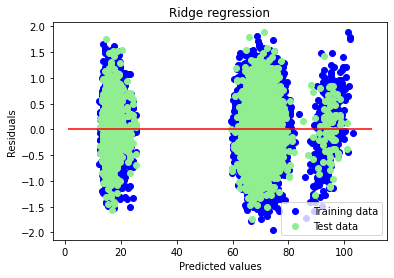

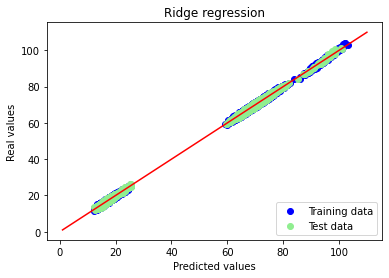

In [58]:
#plot residuals versus predictions
plt.scatter(ridge_train_preds['preds'], ridge_train_preds['residuals'], c='blue', label='Training data')
plt.scatter(ridge_test_preds['preds'], ridge_test_preds['residuals'], c='lightgreen', label='Test data')
plt.title('Ridge regression')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='lower right')
plt.hlines(y=0, xmin=1, xmax=110, color='red')
plt.show()

#plot real values versus predictions
plt.scatter(ridge_train_preds['preds'], ridge_train_preds['true'], c='blue', label='Training data')
plt.scatter(ridge_test_preds['preds'], ridge_test_preds['true'], c='lightgreen', label='Test data')
plt.title('Ridge regression')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc='lower right')
plt.plot([1, 110], [1, 110], c='red')
plt.show()

In [59]:
ridge_mse = mean_squared_error(ridge_test_preds['true'], ridge_test_preds['preds'])
print('MSE on the test data for ridge regression:', ridge_mse.round(4))

MSE on the test data for ridge regression: 0.2546


#### _3.3 Linear regression with LASSO regularisation_

In [60]:
#fit model using cross-validated penalty term
lasso = LassoCV(cv=10, max_iter=10000)
lasso.fit(X_train, np.ravel(y_train))

#store predicted values and residuals on training data
lasso_train_preds = pd.DataFrame({'preds':lasso.predict(X_train), 'true':np.ravel(y_train)})
lasso_train_preds['residuals'] = lasso_train_preds['true'] - lasso_train_preds['preds']

#store predicted values and residuals on test data
lasso_test_preds = pd.DataFrame({'preds':lasso.predict(X_test), 'true':np.ravel(y_test)})
lasso_test_preds['residuals'] = lasso_train_preds['true'] - lasso_train_preds['preds']

In [61]:
print("Optimal LASSO Lambda: {0}".format(lasso.alpha_.round(4)))

Optimal LASSO Lambda: 0.0248


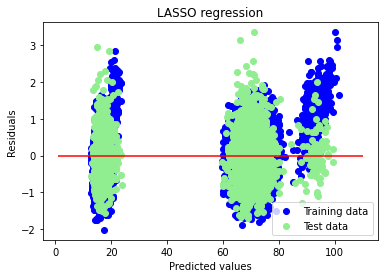

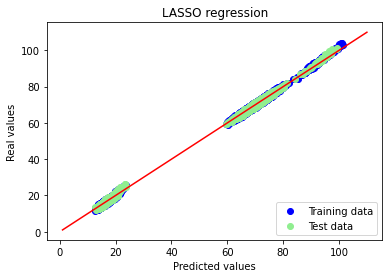

In [62]:
#plot residuals versus predictions
plt.scatter(lasso_train_preds['preds'], lasso_train_preds['residuals'], c='blue', label='Training data')
plt.scatter(lasso_test_preds['preds'], lasso_test_preds['residuals'], c='lightgreen', label='Test data')
plt.title('LASSO regression')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='lower right')
plt.hlines(y=0, xmin=1, xmax=110, color='red')
plt.show()

#plot real values versus predictions
plt.scatter(lasso_train_preds['preds'], lasso_train_preds['true'], c='blue', label='Training data')
plt.scatter(lasso_test_preds['preds'], lasso_test_preds['true'], c='lightgreen', label='Test data')
plt.title('LASSO regression')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc='lower right')
plt.plot([1, 110], [1, 110], c='red')
plt.show()

In [63]:
lasso_mse = mean_squared_error(lasso_test_preds['true'], lasso_test_preds['preds'])
print('MSE on the test data for LASSO regression:', lasso_mse.round(4))

MSE on the test data for LASSO regression: 0.3373


#### _3.3 Linear regression with ElasticNet regularisation_

In [64]:
#fit model using cross-validated penalty term
enet_cv = ElasticNetCV(l1_ratio=np.linspace(0.01, 1, 100), cv=10, max_iter=10000)
enet_cv.fit(X_train,np.ravel(y_train))

#store as ElasticNet object
enet = ElasticNet(alpha=enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_, max_iter=10000)
enet.fit(X_train, np.ravel(y_train))

#store predicted values and residuals on training data
enet_train_preds = pd.DataFrame({'preds':enet.predict(X_train), 'true':np.ravel(y_train)})
enet_train_preds['residuals'] = enet_train_preds['true'] - enet_train_preds['preds']

#store predicted values and residuals on test data
enet_test_preds = pd.DataFrame({'preds':enet.predict(X_test), 'true':np.ravel(y_test)})
enet_test_preds['residuals'] = enet_train_preds['true'] - enet_train_preds['preds']

In [65]:
print("Optimal ElasticNet Lambda: {0}".format(enet_cv.alpha_.round(4)))
print("Optimal ElasticNet L1 Ratio: {0}".format(enet_cv.l1_ratio_.round(4)))

Optimal ElasticNet Lambda: 0.0248
Optimal ElasticNet L1 Ratio: 1.0


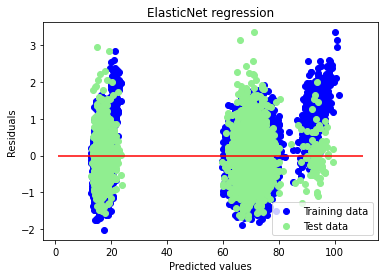

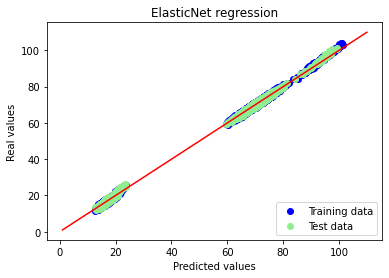

In [66]:
#plot residuals versus predictions
plt.scatter(enet_train_preds['preds'], enet_train_preds['residuals'], c='blue', label='Training data')
plt.scatter(enet_test_preds['preds'], enet_test_preds['residuals'], c='lightgreen', label='Test data')
plt.title('ElasticNet regression')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='lower right')
plt.hlines(y=0, xmin=1, xmax=110, color='red')
plt.show()

#plot real values versus predictions
plt.scatter(enet_train_preds['preds'], enet_train_preds['true'], c='blue', label='Training data')
plt.scatter(enet_test_preds['preds'], enet_test_preds['true'], c='lightgreen', label='Test data')
plt.title('ElasticNet regression')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc='lower right')
plt.plot([1, 110], [1, 110], c='red')
plt.show()

In [67]:
enet_mse = mean_squared_error(enet_test_preds['true'], enet_test_preds['preds'])
print('MSE on the test data for ElasticNet regression:', enet_mse.round(4))

#same as LASSO result (L1_ratio=1) despite ridge achieving better MSE

MSE on the test data for ElasticNet regression: 0.3373


#### _3.4 K-Nearest neighbors regression_

In [68]:
#set up cross-validation procedure for optimising k
cv_scores = []
k_vals = []
 
for k in range(1, 10, 1):
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = -cross_val_score(knn, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    score = scores.mean()
    print("k={0}, cv_score={1:.2f}".format(k, score))
    cv_scores.append(score)
    k_vals.append(k)

#find best performing k
knn_idx = np.argmin(cv_scores)

#store as KNN object
knn = KNeighborsRegressor(n_neighbors=k_vals[knn_idx])
knn.fit(X_train, np.ravel(y_train))

#store predicted values and residuals on training data
knn_train_preds = pd.DataFrame({'preds':knn.predict(X_train), 'true':np.ravel(y_train)})
knn_train_preds['residuals'] = knn_train_preds['true'] - knn_train_preds['preds']

#store predicted values and residuals on test data
knn_test_preds = pd.DataFrame({'preds':knn.predict(X_test), 'true':np.ravel(y_test)})
knn_test_preds['residuals'] = knn_train_preds['true'] - knn_train_preds['preds']

k=1, cv_score=0.54
k=2, cv_score=0.41
k=3, cv_score=0.38
k=4, cv_score=0.38
k=5, cv_score=0.38
k=6, cv_score=0.38
k=7, cv_score=0.39
k=8, cv_score=0.41
k=9, cv_score=0.42


In [69]:
print("k={0} achieved lowest CV MSE of {1:.2f}".format(k_vals[knn_idx], cv_scores[knn_idx]))

k=4 achieved lowest CV MSE of 0.38


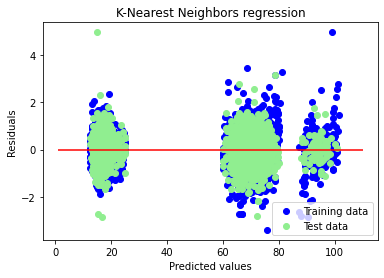

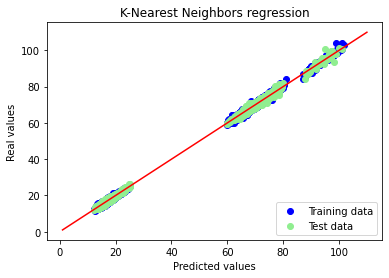

In [70]:
#plot residuals versus predictions
plt.scatter(knn_train_preds['preds'], knn_train_preds['residuals'], c='blue', label='Training data')
plt.scatter(knn_test_preds['preds'], knn_test_preds['residuals'], c='lightgreen', label='Test data')
plt.title('K-Nearest Neighbors regression')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='lower right')
plt.hlines(y=0, xmin=1, xmax=110, color='red')
plt.show()

#plot real values versus predictions
plt.scatter(knn_train_preds['preds'], knn_train_preds['true'], c='blue', label='Training data')
plt.scatter(knn_test_preds['preds'], knn_test_preds['true'], c='lightgreen', label='Test data')
plt.title('K-Nearest Neighbors regression')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc='lower right')
plt.plot([1, 110], [1, 110], c='red')
plt.show()

In [71]:
knn_mse = mean_squared_error(knn_test_preds['true'], knn_test_preds['preds'])
print('MSE on the test data for K-Nearest Neighbors regression:', knn_mse.round(4))

MSE on the test data for K-Nearest Neighbors regression: 0.3775


#### _3.5 Neural Net_

In [72]:
#set up neural network architecture
nn = Sequential()
nn.add(Dense(8, input_dim=16, activation='relu'))
nn.add(Dense(8, activation='relu'))
nn.add(Dense(1, activation='linear'))

#train neural net on training data, optimising for mse
nn.compile(loss='MSE', optimizer='adam')
nn.fit(X_train, y_train, epochs=100, batch_size=10)

#store predicted values and residuals on training data
nn_train_preds = pd.DataFrame({'preds':np.ravel(nn.predict(X_train)), 'true':np.ravel(y_train)})
nn_train_preds['residuals'] = nn_train_preds['true'] - nn_train_preds['preds']

#store predicted values and residuals on test data
nn_test_preds = pd.DataFrame({'preds':np.ravel(nn.predict(X_test)), 'true':np.ravel(y_test)})
nn_test_preds['residuals'] = nn_test_preds['true'] - nn_test_preds['preds']

2022-02-18 01:59:17.033154: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-18 01:59:17.041126: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-18 01:59:17.086565: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-02-18 01:59:17.086655: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: lachy-lt
2022-02-18 01:59:17.086680: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: lachy-lt
2022-02-18 01:59:17.086968: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-02-18 01:59:17.087075: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.86.0
2022-02-18 01:59:1

Epoch 1/100
1760/1760 [==============================] - 1s 431us/step - loss: 1802.6573
Epoch 2/100
1760/1760 [==============================] - 1s 501us/step - loss: 2.4375
Epoch 3/100
1760/1760 [==============================] - 1s 745us/step - loss: 0.6158
Epoch 4/100
1760/1760 [==============================] - 1s 708us/step - loss: 0.4098
Epoch 5/100
1760/1760 [==============================] - 1s 691us/step - loss: 0.3398
Epoch 6/100
1760/1760 [==============================] - 1s 681us/step - loss: 0.3361
Epoch 7/100
1760/1760 [==============================] - 1s 687us/step - loss: 0.3259
Epoch 8/100
1760/1760 [==============================] - 1s 692us/step - loss: 0.3234
Epoch 9/100
1760/1760 [==============================] - 1s 689us/step - loss: 0.3211
Epoch 10/100
1760/1760 [==============================] - 1s 686us/step - loss: 0.3154
Epoch 11/100
1760/1760 [==============================] - 1s 688us/step - loss: 0.3068
Epoch 12/100
1760/1760 [=========================

1760/1760 [==============================] - 1s 555us/step - loss: 0.2777
Epoch 96/100
1760/1760 [==============================] - 1s 558us/step - loss: 0.2717
Epoch 97/100
1760/1760 [==============================] - 1s 539us/step - loss: 0.2743
Epoch 98/100
1760/1760 [==============================] - 1s 566us/step - loss: 0.2789
Epoch 99/100
1760/1760 [==============================] - 1s 619us/step - loss: 0.2759
Epoch 100/100
1760/1760 [==============================] - 1s 609us/step - loss: 0.2797


In [73]:
mse_nn = mean_squared_error(nn_test_preds['true'], nn_test_preds['preds'])
print('\n MSE on the test data for neural net:', mse_nn.round(4))


 MSE on the test data for neural net: 0.2618


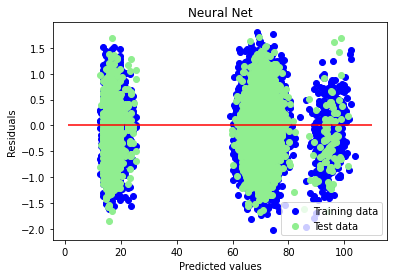

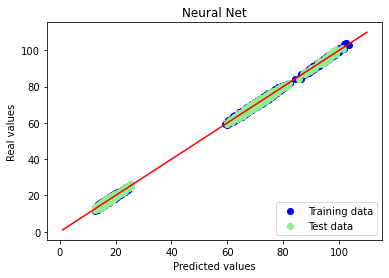

In [74]:
#plot residuals versus predictions
plt.scatter(nn_train_preds['preds'], nn_train_preds['residuals'], c='blue', label='Training data')
plt.scatter(nn_test_preds['preds'], nn_test_preds['residuals'], c='lightgreen', label='Test data')
plt.title('Neural Net')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='lower right')
plt.hlines(y=0, xmin=1, xmax=110, color='red')
plt.show()

#plot real values versus predictions
plt.scatter(nn_train_preds['preds'], nn_train_preds['true'], c='blue', label='Training data')
plt.scatter(nn_test_preds['preds'], nn_test_preds['true'], c='lightgreen', label='Test data')
plt.title('Neural Net')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc='lower right')
plt.plot([1, 110], [1, 110], c='red')
plt.show()

### 4. Model Evaluation

In [75]:
#create table to store training mse scores for standard models
columns = ['Train MSE']
rows = ['LinearReg', 'Ridge', 'Lasso', 'ElasticNet', 'K-Nearest', 'Neural Net']
regressions = [lr, ridge, lasso, enet, knn, nn] #defined above
train_error = pd.DataFrame(0.0, columns=columns, index=rows) #initialise dataframe to hold results

methods = {k: v for k, v in zip(rows, regressions)} #dictionary pairing df rows to regression models

keys = ['LinearReg', 'Ridge', 'Lasso', 'ElasticNet', 'K-Nearest', 'Neural Net']
for key in keys:
    scores = mean_squared_error(y_train, methods[key].predict(X_train))
    
    train_error.loc[key] = scores

In [76]:
#create table to store test mse scores for standard models
columns = ['Test MSE']
test_error = pd.DataFrame(0.0, columns=columns, index=rows) #initialise dataframe to hold results

for key in keys:
    scores = mean_squared_error(y_test, methods[key].predict(X_test))
    
    test_error.loc[key] = scores

In [77]:
#combine scores into results table and print
results = pd.concat([train_error, test_error], axis=1)
results.round(4)

,Train MSE,Test MSE
LinearReg,0.2512,0.2546
Ridge,0.2512,0.2546
Lasso,0.3282,0.3373
ElasticNet,0.3282,0.3373
K-Nearest,0.2643,0.3775
Neural Net,0.2558,0.2618


### 5. For the marker: Test Error

In [78]:
#split test into predictors and ground truth
predictors = pd.concat([test[numerical_features], test[categorical_features]], axis=1)
ground_truth = test[target]

In [79]:
#identify best performing model
idx = np.argmin(results['Test MSE'])

In [80]:
#print best model
best_model = regressions[idx]
print(best_model)

#ridge model with alpha=0.001...

Ridge(alpha=0.0011667805215364697)


In [81]:
#calculate test error of best model
test_error = mean_squared_error(ground_truth, ridge.predict(predictors)).round(4)

In [82]:
#print test error
print(test_error)

0.2327
